By talking about individual differences, cognitive scientists are referring to individual notions in exhibited behavior, e.g. different learning rates.

In this simple case, we are going to collect data from two participants with two individual learning rates and try to recover them once with the last RNN and a version which implements a participant-embedding layer.

<!-- 
But this thought can go even deeper if we not only consider different parameterizations for each participant but also different model architectures for each participant!

Think of the following scenario: 

One participant exhibits only goal-directed behavior (i.e. making choices based only on the reward-based values) while another participant shows an additional positivity bias (i.e. increasing the learning rate for positive outcomes while the value is low and a decreasing the learning rate for negative outcomes while the value is high). Such a positivity bias can help to account for reward volatility, by preventing to drastic value updates in the case of an unexpected penalty ($reward = 0$). Additionally, it can also induce goal-directed exploration by making more drastic updates in the case of an unexpected reward.  -->

<!-- But that's enough theory for now. Let's get our hands dirty again! -->

So first of all we have to generate a dataset with multiple participants. Let's start with two different ones.

we are going generate half the dataset with participant #1 and the other half with participant #2.

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from spice.resources.bandits import BanditsDrift
from spice.resources.bandits import AgentQ, AgentNetwork
from spice.resources.bandits import create_dataset
from spice.resources.rnn import BaseRNN
from spice.resources.rnn_utils import DatasetRNN
from spice.resources.rnn_training import fit_model
from spice.utils.plotting import plot_session
from spice.estimator import SpiceEstimator

In [14]:
import sys, os

# Get the current working directory (where the notebook is running)
dir_current = os.getcwd()

# Define the path to the project directory
dir_project = os.path.join(dir_current, "..")

# Add the project directoy to the Python path to make the subpackages visible
sys.path.append(dir_project)


np.random.seed(42)
torch.manual_seed(42)

n_actions = 2
n_trials = 200
n_sessions=256
environment = BanditsDrift(sigma=0.2)

# SINDy configuration
# Add already here the new module and update the library and filter setup.
list_rnn_modules = ['x_learning_rate_reward', 'x_value_reward_not_chosen']

# add here a control parameter for the reward-based value which serves as an additional input to the learning-rate
list_control_signals = ['c_action', 'c_reward', 'c_value_reward']

# The new module which handles the not-chosen value, does not need any additional inputs except for the value
library_setup = {
    # 'x_value_reward_chosen': ['c_reward'] -> Remove this one from the library as we are not going to identify the dynamics of a hard-coded equation
    'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
    'x_value_reward_not_chosen': [],
    }

# Further, the new module should be applied only to the not-chosen values
filter_setup = {
    # 'x_value_reward_chosen': ['c_action', 1, True], -> Remove this one as well
    'x_learning_rate_reward': ['c_action', 1, True],
    'x_value_reward_not_chosen': ['c_action', 0, True],
}

In [15]:
# participant #1
agent_1 = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.8,
)

dataset_1, _, _ = create_dataset(
    agent=agent_1,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions//2,
)

# change the participant id of all sessions to 0
dataset_1.xs[..., -1] = 0

# participant #2
agent_2 = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.2,
)

dataset_2, _, _ = create_dataset(
    agent=agent_2,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions//2,
)

# change the participant id of all sessions to 1
dataset_2.xs[..., -1] = 1

# concatenate the two datasets
dataset_xs = torch.cat((dataset_1.xs, dataset_2.xs))
dataset_ys = torch.cat((dataset_1.ys, dataset_2.ys))
dataset = DatasetRNN(dataset_xs, dataset_ys)

print(f'Shape of the new dataset: {dataset.xs.shape}')
print(f'Number of participants: {len(dataset.xs[..., -1].unique())}')

Shape of the new dataset: torch.Size([256, 200, 5])
Number of participants: 2


Let's see how different these two participants behave

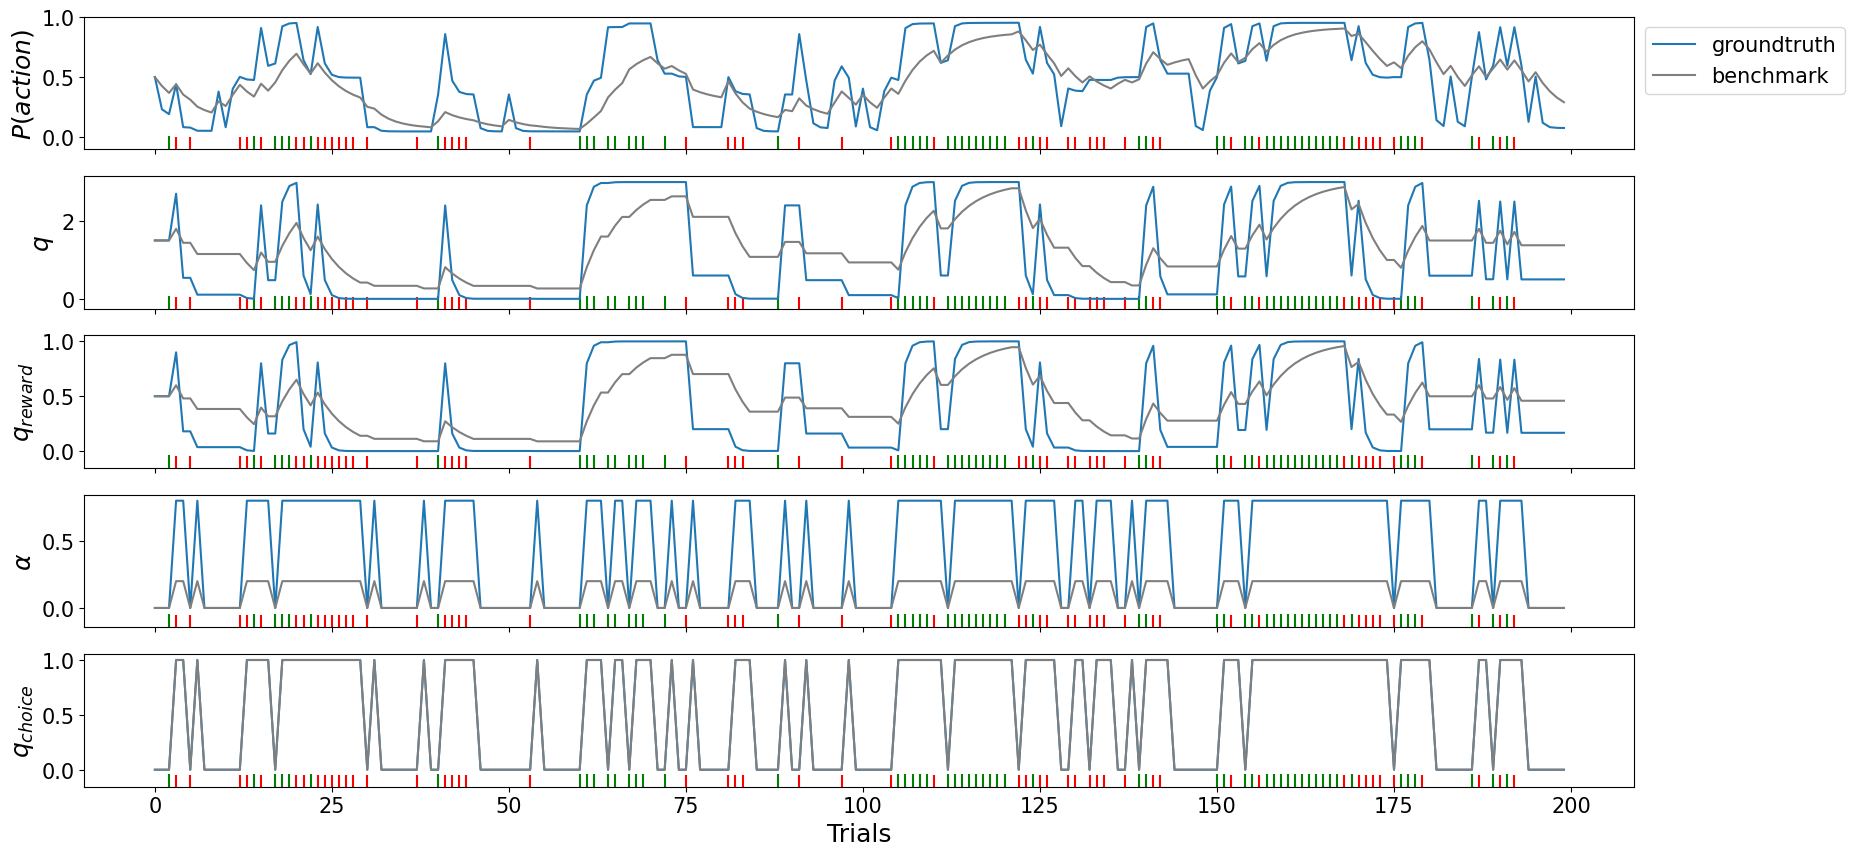

In [16]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_1, 'benchmark': agent_2}
fig, axs = plot_session(agents, dataset.xs[0])

plt.show()

Let's inspect first how our last RNN would perform in such a situation to verify the need for tackling individual differences with a participant-embedding layer.

In [17]:
class RLRNN(BaseRNN):
    
    # add an additional memory state by defining a new initial value for that state
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,
        }
    
    def __init__(
        self,
        n_actions,
        list_signals,
        **kwargs,
    ):
        
        super(RLRNN, self).__init__(n_actions=n_actions, hidden_size=8, list_signals=list_signals)
        
        # set up the submodules
        # switch from 'x_value_reward_chosen' to 'x_learning_rate_reward' to compute the learning rate based on the current reward-based value and the reward  
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)
        
        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
        # add a scaling factor (i.e. inverse noise temperature) for 'x_value_reward'
        self.betas = torch.nn.ParameterDict()
        self.betas['x_value_reward'] = torch.nn.Parameter(torch.tensor(1.))
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _ = inputs
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
            self.record_signal('x_learning_rate_reward', self.state['x_learning_rate_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            
            # Let's compute the learning rate dynamically
            # Now we have to use a sigmoid activation function on the output learning rate to constrain it to a value range of (0, 1)
            # this is necessary for two reasons:
            #   1. Preventing exploding gradients
            #   2. Remember the found equation for 'x_value_reward_chosen' from before: 
            #       The learning rate was scaled according to the magnitudes of the reward and the actual value 
            #       e.g. for the reward: alpha*beta -> alpha * beta = 0.3 * 3 = 0.9 and for the reward-based value: 1-alpha = 1 - 0.3 = 0.7
            #       The hard-coded equation for the reward-prediction error does not permit this flexibility. 
            #       But we can circumvein this by applying the sigmoid activation to the learning rate to staying conform with the reward-prediction error
            #       and later applying the inverse noise temperature (i.e. trainable parameter) to the updated value 
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            # updating the memory state
            self.state['x_learning_rate_reward'] = learning_rate_reward
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward']
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

In [18]:
model_rnn = RLRNN(n_actions=n_actions, list_signals=list_rnn_modules+list_control_signals)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

spice_estimator = SpiceEstimator(
    rnn_class=RLRNN,
    rnn_modules=list_rnn_modules,
    control_parameters=list_control_signals,
    sindy_library_config=library_setup,
    sindy_filter_config=filter_setup,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    list_signals=list_rnn_modules+list_control_signals,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)

Library setup is valid. All keys and features appear in the provided list of features.

Training the RNN...
Epoch 1/1024 --- L(Train): 1.6612038; Time: 0.10s; Convergence: 8.31e-01
Epoch 2/1024 --- L(Train): 1.2299526; Time: 0.10s; Convergence: 6.31e-01
Epoch 3/1024 --- L(Train): 0.9564106; Time: 0.10s; Convergence: 4.52e-01
Epoch 4/1024 --- L(Train): 0.7790103; Time: 0.10s; Convergence: 3.15e-01
Epoch 5/1024 --- L(Train): 0.6487483; Time: 0.10s; Convergence: 2.23e-01
Epoch 6/1024 --- L(Train): 0.5847334; Time: 0.10s; Convergence: 1.43e-01
Epoch 7/1024 --- L(Train): 0.5671930; Time: 0.10s; Convergence: 8.04e-02
Epoch 8/1024 --- L(Train): 0.5635305; Time: 0.10s; Convergence: 4.20e-02
Epoch 9/1024 --- L(Train): 0.5630736; Time: 0.10s; Convergence: 2.12e-02
Epoch 10/1024 --- L(Train): 0.5628588; Time: 0.10s; Convergence: 1.07e-02
Epoch 11/1024 --- L(Train): 0.5624420; Time: 0.10s; Convergence: 5.57e-03
Epoch 12/1024 --- L(Train): 0.5619245; Time: 0.10s; Convergence: 3.05e-03
Epoch 13/1024

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 4.7162e-01 ... 2.4896e-01 ... 5.3032e-02 ... 5.2714e-01
        10 ... 5.8320e-01 ... 1.6578e-01 ... 4.6620e-02 ... 6.3147e-01
(x_learning_rate_reward)[k+1] = 0.500 1

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 9.6118e-03 ... 1.1200e-01 ... 8.9006e-02 ... 9.9738e-02
        10 ... 1.4341e-01 ... 9.3309e-02 ... 8.3797e-02 ... 2.2814e-01
        20 ... 1.4460e-01 ... 9.3398e-02 ... 8.3785e-02 ... 2.2931e-01
(x_value_reward_not_chosen)[k+1] = 0.955 x_value_reward_not_chosen[k]


100%|██████████| 1/1 [00:00<00:00,  2.09it/s]


SINDy training finished.
Training took 103.47 seconds.


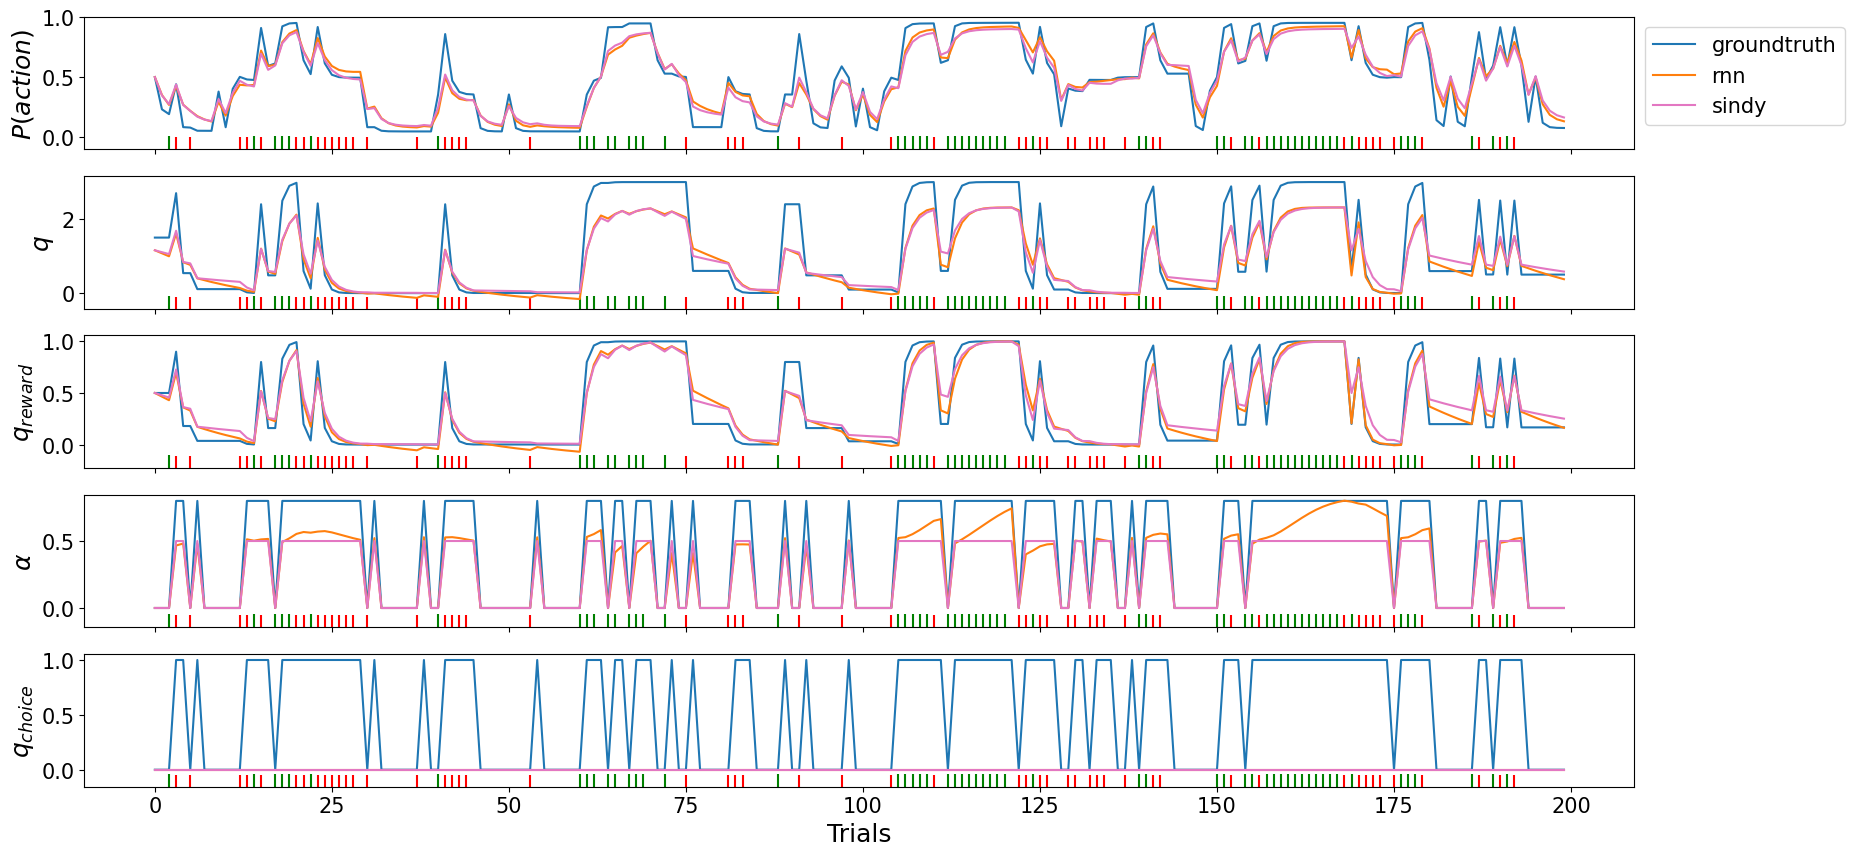

In [19]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_1, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.sindy_agent}
fig, axs = plot_session(agents, dataset_1.xs[0])
plt.show()

And now for participant #2

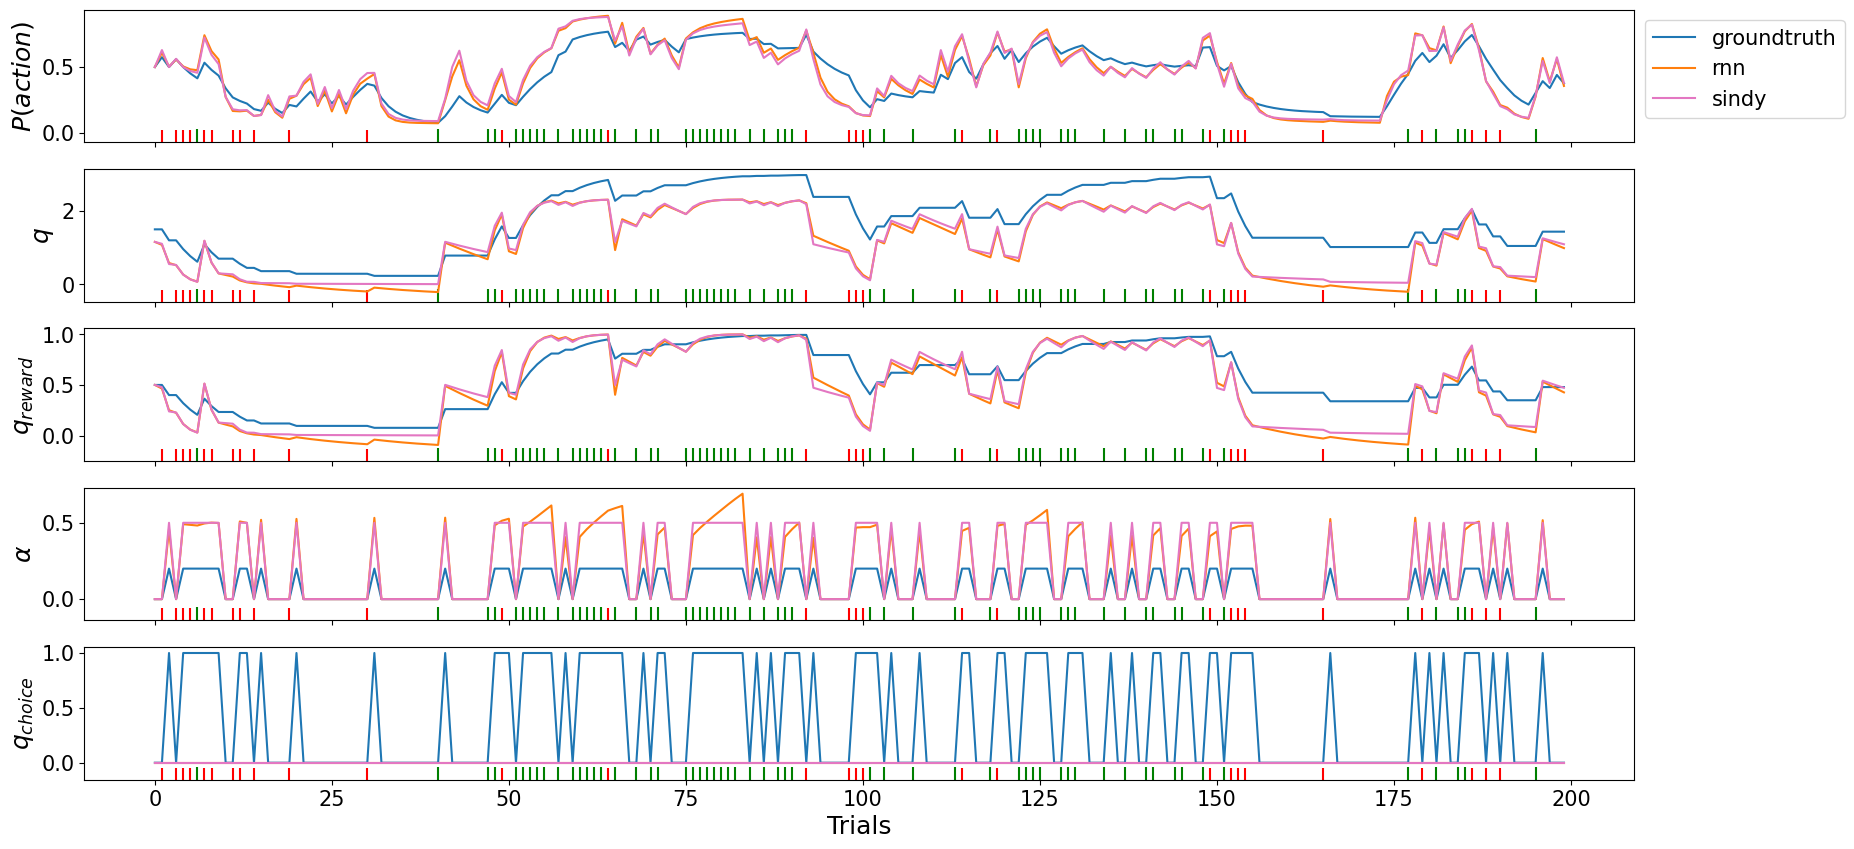

In [20]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_2, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.sindy_agent}
fig, axs = plot_session(agents, dataset_2.xs[0])
plt.show()

The fit across both participants is  worse compared to the other use-cases, where we had only one participant to fit. 

Therefore, we can definitely see the need for modeling individual differences - already in this case. The need is even stronger for real datasets with dozens of participants.  

Let's implement now a RNN which can be trained on the whole dataset but account for the differences in the individuals' behavior.

For that we are going to add a participant-embedding layer. It works similar to e.g. word-embeddings which translate a one-hot encoded vector into a dense representation in a multidimensional space.

The one-hot encoded vector corresponds to e.g. a dictionary marking the index of a certain word. After translating this word into the multidimensional space, researchers can do inference on word similarity or try to interpret the representation and extract characteristics from it.

We are making use of the embedding layer by passing a unique participant id into it and retrieve a dense representation of this participant. Afterwards we can feed this representation to the RNN-modules or compute individual noise temperatures.

That way the RNN-modules can learn *(theoretically)* any type of cognitive mechanism present in the data across all participants and the participant-embedding can give the individual notions to them by e.g. switching mechanisms on and off and parameterizing them.

In [21]:
class RLRNN(BaseRNN):
    
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,
        }
    
    def __init__(
        self,
        n_actions,
        # add an additional inputs to set the number of participants in your data
        n_participants,
        list_signals,
        **kwargs,
    ):
        
        super(RLRNN, self).__init__(n_actions=n_actions, list_signals=list_signals)
        
        # specify here the participant-specifc parts
        self.embedding_size = 8
        self.participant_embedding = torch.nn.Embedding(num_embeddings=n_participants, embedding_dim=self.embedding_size)
        
        # and now we are adding for each participant a scaling factor (inverse noise temperature).
        # but this time, we want to use the participant embedding as an input
        self.betas = torch.nn.ModuleDict()
        self.betas['x_value_reward'] = torch.nn.Sequential(torch.nn.Linear(self.embedding_size, 1), torch.nn.ReLU())
        
        # and here we specify the general architecture
        # add to the input_size the embedding_size as well because we are going to pass the participant-embedding to the RNN-modules
        # set up the submodules
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2+self.embedding_size, dropout=0.)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0+self.embedding_size, dropout=0.)
        
        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, participant_id = inputs
        
        # Here we compute now the participant embeddings for each entry in the batch
        participant_embedding = self.participant_embedding(participant_id[:, 0].int())
        # beta_value_reward = self.betas['x_value_reward'](participant_embedding)
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
            self.record_signal('x_learning_rate_reward', self.state['x_learning_rate_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                # add participant-embedding (for RNN-modules) and participant-index (later for SINDy-modules) 
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                participant_embedding=participant_embedding,
                participant_index=participant_id,
                )
            
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            self.state['x_learning_rate_reward'] = learning_rate_reward
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward'](participant_embedding)
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

We are now going to fit the RNN with participant-embedding to the data of the two participants. As you can imagine the individual differences can be quite subtle. Unlike big architectural differences, individual differences have to be fitted very cautiously, i.e. in the machine learning context with a very low learning rate.

Low learning rates have a couple of disadvantages, i.e. (1) they take very long to converge, and (2) they can get stuck easily in local minima. 

These are the reasons why we should use a learning rate scheduler in this scenario. The implemented learning rate scheduler can be activated in the fitting method by setting `scheduler=True`. This way we are making use of a learning rate scheduler which adjusts the learning rate dynamically.

In [28]:
# get the number of participants from your data
participant_ids = dataset.xs[..., -1].unique()
n_participants = len(participant_ids)
model_rnn = RLRNN(n_actions=n_actions, n_participants=n_participants, list_signals=list_rnn_modules+list_control_signals)

spice_estimator = SpiceEstimator(
    rnn_class=RLRNN,
    rnn_modules=list_rnn_modules,
    n_participants=n_participants,
    control_parameters=list_control_signals,
    sindy_library_config=library_setup,
    sindy_filter_config=filter_setup,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    convergence_threshold=0,
    scheduler=True,
    sindy_library_polynomial_degree=2,
    sindy_optim_regularization=0.1,
    sindy_optim_threshold=0.05,
    list_signals=list_rnn_modules+list_control_signals,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)

Library setup is valid. All keys and features appear in the provided list of features.

Training the RNN...
Epoch 1/1024 --- L(Train): 0.6931473; Time: 0.13s; Convergence: 6.53e-01; LR: 0.00e+00
Epoch 2/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 3.27e-01; LR: 7.81e-04
Epoch 3/1024 --- L(Train): 0.6931473; Time: 0.13s; Convergence: 1.63e-01; LR: 1.56e-03
Epoch 4/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 8.17e-02; LR: 2.34e-03
Epoch 5/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 4.08e-02; LR: 3.13e-03
Epoch 6/1024 --- L(Train): 0.6931689; Time: 0.12s; Convergence: 2.04e-02; LR: 3.91e-03
Epoch 7/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 1.02e-02; LR: 4.69e-03
Epoch 8/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 5.11e-03; LR: 5.47e-03
Epoch 9/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 2.56e-03; LR: 6.25e-03
Epoch 10/1024 --- L(Train): 0.6931473; Time: 0.12s; Convergence: 1.28e-03; LR: 7.03e-03
Epoch 11/1024 --- L(T

  0%|          | 0/2 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 2.1806e-07 ... 3.2448e-02 ... 2.0956e-02 ... 2.4201e-02
(x_learning_rate_reward)[k+1] = 0.777 1

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 2.4019e-05 ... 2.6680e-02 ... 2.5339e-02 ... 2.8031e-02
        10 ... 4.9989e-03 ... 4.5168e-02 ... 2.5298e-02 ... 3.4814e-02
(x_value_reward_not_chosen)[k+1] = 1.013 x_value_reward_not_chosen[k]


 50%|█████     | 1/2 [00:00<00:00,  1.71it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 2.7674e-09 ... 3.2416e-02 ... 6.2176e-03 ... 9.4592e-03
(x_learning_rate_reward)[k+1] = 0.201 1

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 5.5201e-06 ... 2.8203e-02 ... 2.5186e-02 ... 2.8011e-02
        10 ... 8.3836e-03 ... 4.6712e-02 ... 2.5091e-02 ... 3.8146e-02
(x_value_reward_not_chosen)[k+1] = 1.003 x_value_reward_not_chosen[k]


100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


SINDy training finished.
Training took 130.19 seconds.


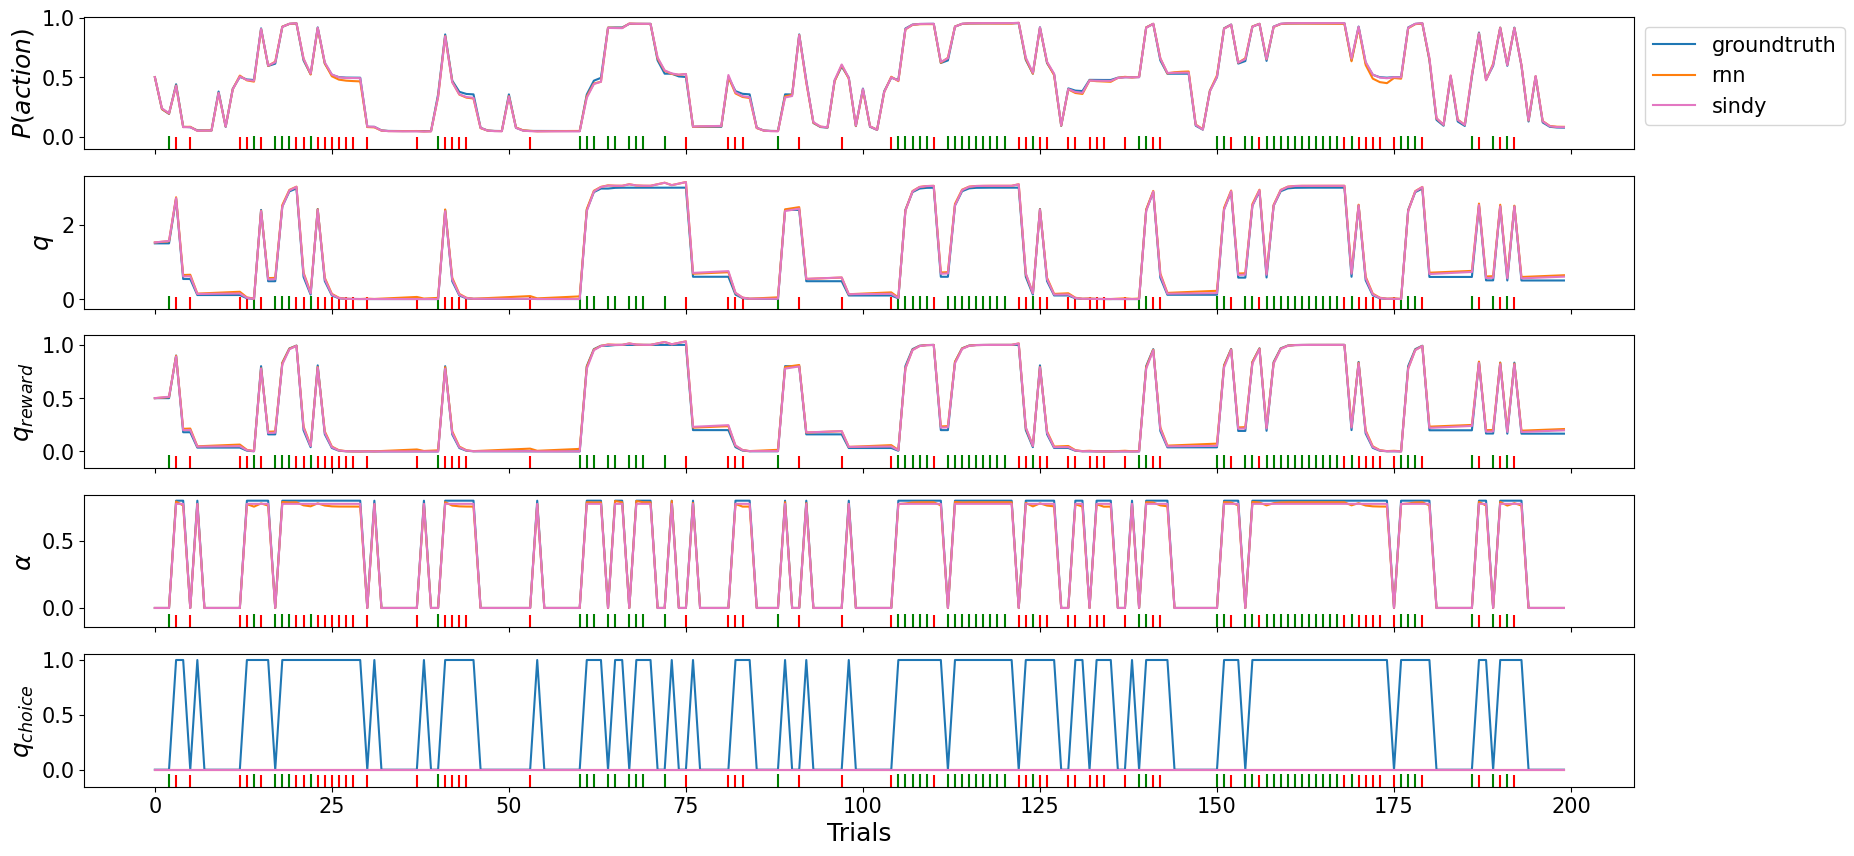

In [29]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_1, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.sindy_agent}
fig, axs = plot_session(agents, dataset_1.xs[0])

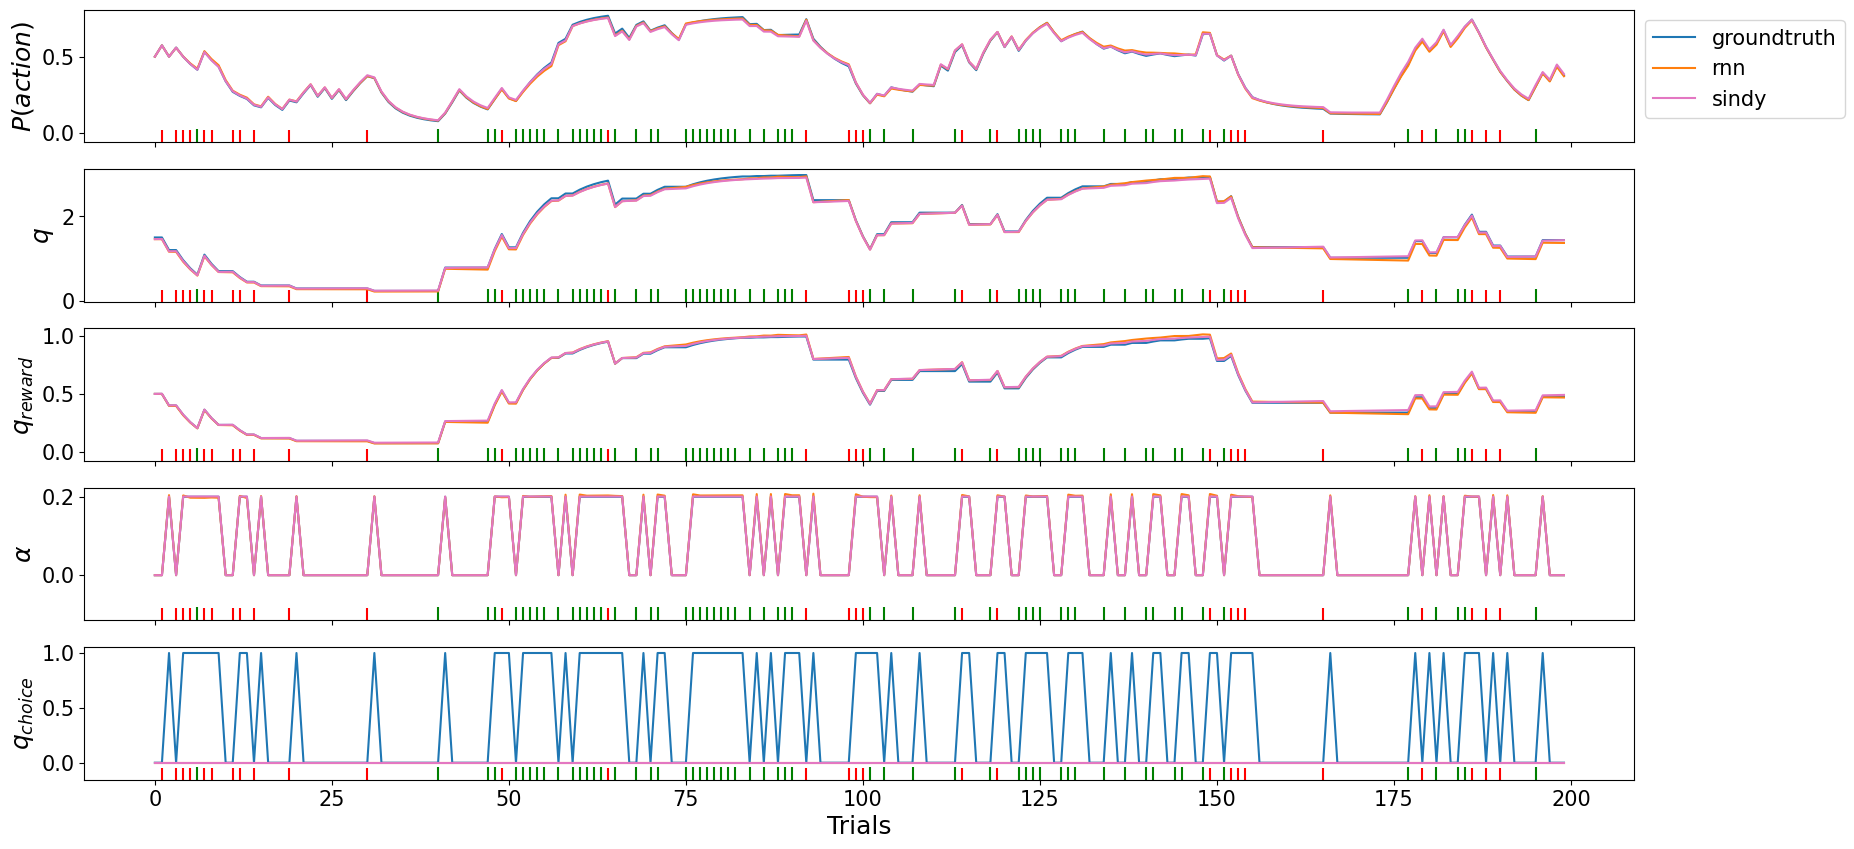

In [30]:
# Let's see how well the dynamics were fitted
agents = {'groundtruth': agent_2, 'rnn': spice_estimator.rnn_agent, 'spice': spice_estimator.sindy_agent}
fig, axs = plot_session(agents, dataset_2.xs[0])